# Transient Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Charging RC Circuit

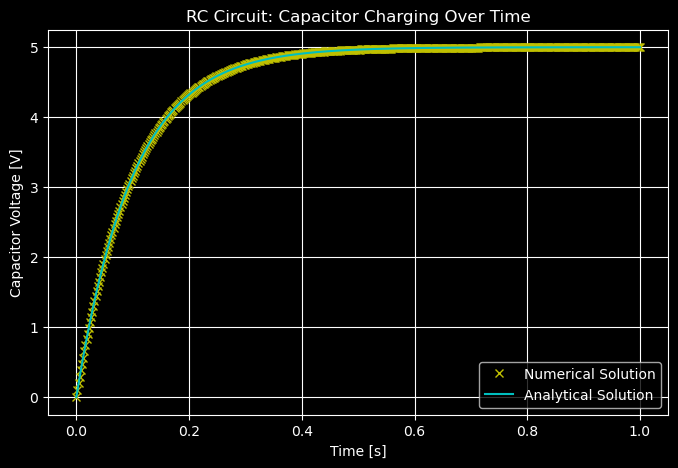

In [2]:
# --- Parameters ---
R = 1e3       # resistance in ohms
C = 100e-6    # capacitance in farads
Vs = 5        # supply voltage in volts

# --- Differential equation: dVc/dt = (Vs - Vc) / (R*C) ---
def dVcdt(t, Vc):
    return (Vs - Vc) / (R * C)

# --- Time range and initial condition ---
t_span = (0, 1)           # simulate for 1 second
Vc0 = [0]                 # initial voltage (capacitor initially uncharged)
t_eval = np.linspace(*t_span, 500)

# --- Solve ODE ---
solution = solve_ivp(dVcdt, t_span, Vc0, t_eval=t_eval)

# --- Analytical solution for comparison ---
Vc_analytical = Vs * (1 - np.exp(-solution.t / (R * C)))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(solution.t, solution.y[0], 'yx', label='Numerical Solution')
plt.plot(solution.t, Vc_analytical, 'c', label='Analytical Solution')
plt.title('RC Circuit: Capacitor Charging Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Capacitor Voltage [V]')
plt.grid(True)
plt.legend()
plt.show()


## Charging RC Circuit (Current)

What does the current through $C$ look like during this charging process?

$$
i_C(t) = C \frac{dV_C(t)}{dt} = \frac{V_0}{R} e^{-\frac{t}{RC}}\left(v_C(\infty)-v_C(0)\right)
$$

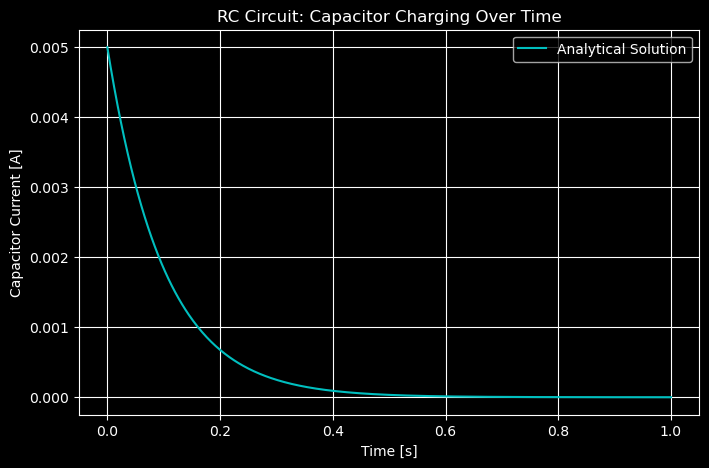

In [3]:
Ic_analytical = (Vs / R) * np.exp(-solution.t / (R * C))

# --- Plot ---
plt.figure(figsize=(8,5))
# plt.plot(solution.t, solution.y[0], 'b', label='Numerical Solution')
plt.plot(solution.t, Ic_analytical, 'c', label='Analytical Solution')
plt.title('RC Circuit: Capacitor Charging Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Capacitor Current [A]')
plt.grid(True)
plt.legend()
plt.show()

Note the discontinuity at time t=0. This is because the capacitor initially behaves like a short circuit, allowing maximum current to flow. As the capacitor charges, the voltage across it increases, reducing the current until it eventually reaches zero when the capacitor is fully charged.

## Discharging RC Circuit

Draw a circuit that allows a capacitor to discharge through a resistor when a switch is moved to position 2 at time t=0.

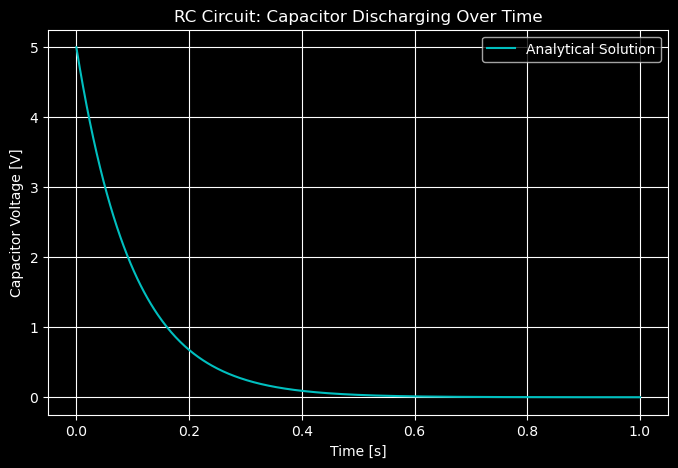

In [4]:
Vc_analytical = Vs * np.exp(-solution.t / (R * C))

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(solution.t, Vc_analytical, 'c', label='Analytical Solution')
plt.title('RC Circuit: Capacitor Discharging Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Capacitor Voltage [V]')
plt.grid(True)
plt.legend()
plt.show()

What is $V_c(t < 0)$?

When the switch is moved to position 2 at time t=0, the capacitor begins to discharge through the resistor.  Prior to that, it is at the steady-state voltage from being charge.

## Secord-Order (RLC) Transient Response

$\frac{1}{\omega^{2}_{n}} \frac{d^2v(t)}{dt^2} + \frac{2\zeta}{\omega_n} \frac{dv(t)}{dt} + v(t) = K_Sf(t)$

Where:
- $\omega_n = \frac{1}{\sqrt{LC}}$ is the undamped natural frequency (rad/s)
- $\zeta = \frac{R}{2} \sqrt{\frac{C}{L}}$ is the damping ratio (unitless)
- $K_S = \frac{1}{L}$ is the system gain (1/Ohms)


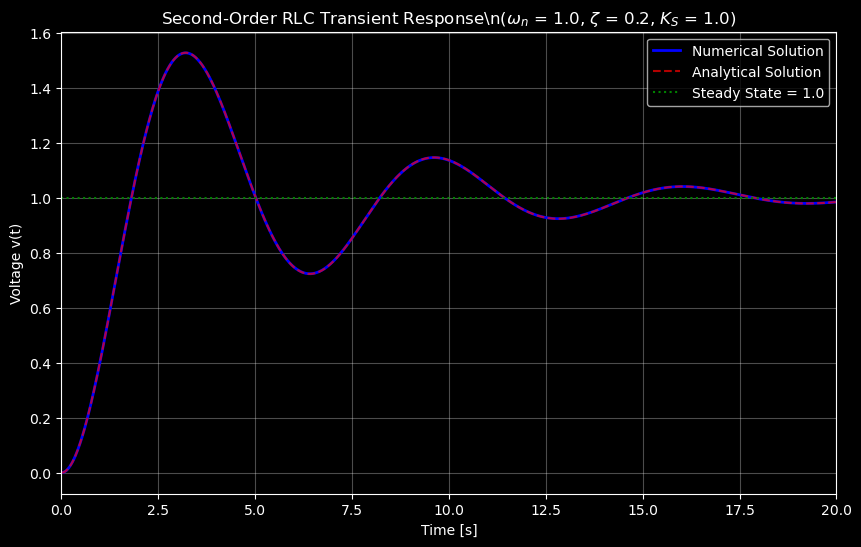

Damped natural frequency: ω_d = 0.980 rad/s
Damped period: T_d = 6.413 s
Overshoot: 52.6%


In [6]:
# --- Parameters ---
omega_n = 1.0    # undamped natural frequency (rad/s)
zeta = 0.2       # damping ratio (underdamped)
K_S = 1.0        # system gain

# For this example, let's use a step input: f(t) = 1 for t >= 0
# The differential equation becomes:
# (1/omega_n^2) * d2v/dt2 + (2*zeta/omega_n) * dv/dt + v = K_S

# Convert to state-space form: let x1 = v, x2 = dv/dt
# dx1/dt = x2
# dx2/dt = omega_n^2 * (K_S - x1 - (2*zeta/omega_n)*x2)

def rlc_system(t, x):
    v = x[0]      # voltage
    dvdt = x[1]   # first derivative
    
    # Second derivative from the differential equation
    d2vdt2 = omega_n**2 * (K_S - v - (2*zeta/omega_n)*dvdt)
    
    return [dvdt, d2vdt2]

# --- Initial conditions ---
v0 = 0       # initial voltage
dvdt0 = 0    # initial rate of change

# --- Time span ---
t_span = (0, 20)  # simulate for 20 seconds (about 3-4 periods for this omega_n)
t_eval = np.linspace(*t_span, 1000)

# --- Solve the ODE ---
solution = solve_ivp(rlc_system, t_span, [v0, dvdt0], t_eval=t_eval, method='RK45')

# --- Calculate analytical solution for underdamped case ---
omega_d = omega_n * np.sqrt(1 - zeta**2)  # damped natural frequency
A = K_S
B = (zeta * omega_n) / omega_d

v_analytical = A * (1 - np.exp(-zeta * omega_n * solution.t) * 
                    (np.cos(omega_d * solution.t) + B * np.sin(omega_d * solution.t)))

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.plot(solution.t, solution.y[0], 'b-', linewidth=2, label='Numerical Solution')
plt.plot(solution.t, v_analytical, 'r--', linewidth=1.5, label='Analytical Solution', alpha=0.7)
plt.axhline(y=K_S, color='g', linestyle=':', label=f'Steady State = {K_S}')
plt.title(rf'Second-Order RLC Transient Response\n($\omega_n$ = {omega_n}, $\zeta$ = {zeta}, $K_S$ = {K_S})')
plt.xlabel('Time [s]')
plt.ylabel('Voltage v(t)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 20)
plt.show()

# Print damped frequency and period
print(f"Damped natural frequency: ω_d = {omega_d:.3f} rad/s")
print(f"Damped period: T_d = {2*np.pi/omega_d:.3f} s")
print(f"Overshoot: {(np.max(solution.y[0]) - K_S)/K_S * 100:.1f}%")

### How to interpret this response

- The natural frequency $\omega_n$ indicates how quickly the system oscillates in the absence of damping.
- $K_S$ indicates the steady-state gain of the system in response to a step input.
- The damping ratio $\zeta$ determines the nature of the transient response:
  - If $\zeta < 1$, the system is underdamped and will exhibit oscillatory behavior before settling to the steady-state value.
  - If $\zeta = 1$, the system is critically damped and will return to steady-state as quickly as possible without oscillating.
  - If $\zeta > 1$, the system is overdamped and will return to steady-state slowly without oscillating.
- $\zeta$ affects the speed of response and the amount of overshoot in the transient response, and it can be modulated by changing the resistance $R$ in the circuit.

### Physical Analogy: Car Suspension System

- $\omega_n$ represents how quickly the car can respond to bumps in the road. 
  - A higher $\omega_n$ means the car can react quickly. 
  - A lower $\omega_n$ means a slower response.
- $\zeta$ represents the damping effect of the shock absorbers. 
  - A higher $\zeta$ means the car will settle down quickly after a bump. 
  - A lower $\zeta$ means it will oscillate more before settling.
- $K_S$ represents how much the car's body moves in response to a bump. 
  - A higher $K_S$ means more movement. 
  - A lower $K_S$ means less movement.